# MPI calibration of a Grid5000 cluster

## Data exploration

In [1]:
import os
from extract_archive import *

archive_name = 'grenoble_2018-08-29_1808879.zip'
result = extract_zip(archive_name)

/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
!unzip -p $archive_name info.yaml

cluster: dahu
command: /home/tocornebize/.local/bin/peanut MPICalibration run tocornebize --jobid
  grenoble:1808879 --deploy debian9-x64-base --expfile exp.csv
dahu-11.grenoble.grid5000.fr:
  arp:
    dns.grenoble.grid5000.fr:
    - (172.16.31.110) at 00:16:3e:4f:65:bf [ether] on enp24s0f0
    fgrenoble.grenoble.grid5000.fr:
    - (172.16.31.101) at 00:16:3e:06:dd:61 [ether] on enp24s0f0
    gw.grenoble.grid5000.fr:
    - (172.16.31.254) at 00:04:96:1d:09:40 [ether] on enp24s0f0
    kadeploy.grenoble.grid5000.fr:
    - (172.16.31.102) at 00:16:3e:c8:38:51 [ether] on enp24s0f0
  cpu: Intel(R) Xeon(R) Gold 6130 CPU @ 2.10GHz
  gcc: 6.3.0
  kernel: 4.9.0-7-amd64
  mpi: mpirun (Open MPI) 2.0.2
  version: 'Linux version 4.9.0-7-amd64 (debian-kernel@lists.debian.org) (gcc version
    6.3.0 20170516 (Debian 6.3.0-18+deb9u1) ) #1 SMP Debian 4.9.110-3+deb9u1 (2018-08-03)'
deployment: debian9-x64-base
expfile: exp.csv
git_repositories:
- hash: 0f9441f8a6e8df814ba2514d7262de771a81ae3d
  path: pl

In [3]:
import pytree
print(pytree.__version__)
print(pytree.__git_version__)

0.0.6
0a153e9e34536887a3b697d1e0df121e8d6b9eeb


In [4]:
import pandas

# Special processing for the Pingpong dataset
df_pingpong = result['exp/exp_PingPong.csv']
pingpong_send = df_pingpong[df_pingpong.op=='MPI_Send'].reset_index(drop=True)
pingpong_recv = df_pingpong[df_pingpong.op=='MPI_Recv'].reset_index(drop=True)
df_pingpong = pandas.DataFrame(dict(op = 'PingPong',
                   msg_size = pingpong_send.msg_size,
                   start    = pingpong_send.start,
                   duration = pingpong_recv.duration + pingpong_send.duration
              ))

df_send = pingpong_send
df_isend = result['exp/exp_Isend.csv']
df_recv = result['exp/exp_Recv.csv']
df_wtime = result['exp/exp_Wtime.csv']
df_test = result['exp/exp_Test.csv']
df_iprobe = result['exp/exp_Iprobe.csv']

### MPI_Send

In [5]:
import pytree
import matplotlib.pyplot as plt

tmp = aggregate_dataframe(df_send)
reg_send = pytree.compute_regression(x=tmp.msg_size, y=tmp.duration).auto_simplify()
print(reg_send.breakpoints)
reg_send

[7904, 15831, 31183, 65493, 136040, 436242, 779429]


-inf < x ≤ 7.904e+03
	y ~ 8.219e-11x + 2.320e-07
7.904e+03 < x ≤ 1.583e+04
	y ~ 8.343e-11x + 3.775e-07
1.583e+04 < x ≤ 3.118e+04
	y ~ 1.253e-11x + 2.663e-06
3.118e+04 < x ≤ 6.549e+04
	y ~ 4.329e-11x + 1.733e-06
6.549e+04 < x ≤ 1.360e+05
	y ~ 4.285e-11x + 2.058e-06
1.360e+05 < x ≤ 4.362e+05
	y ~ 4.931e-11x + 1.088e-06
4.362e+05 < x ≤ 7.794e+05
	y ~ 5.476e-11x + -1.318e-06
7.794e+05 < x ≤ inf
	y ~ 6.080e-11x + -5.991e-06

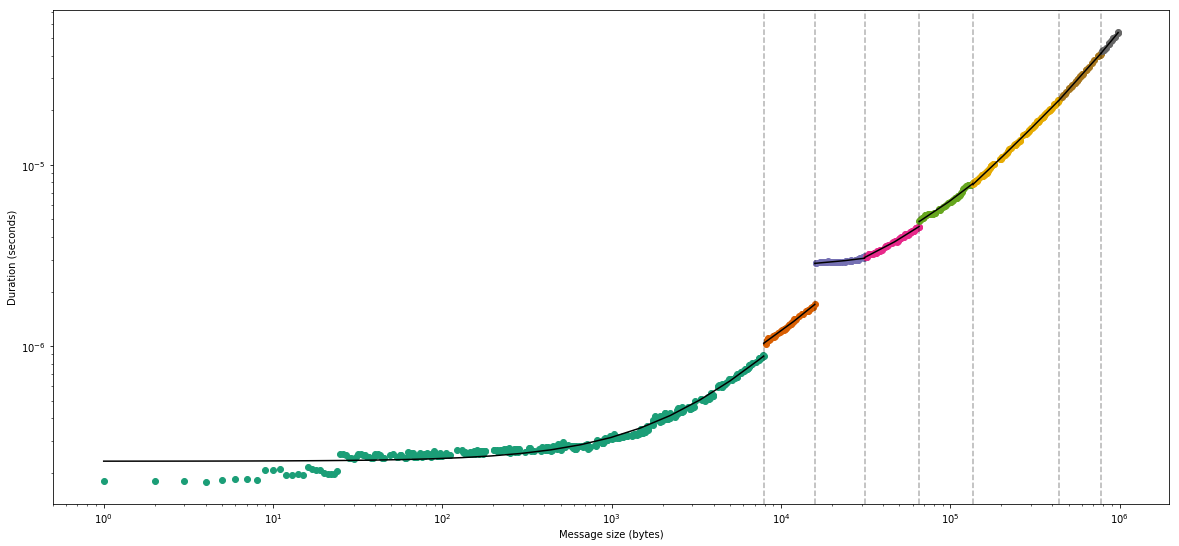

In [6]:
def draw_plot(reg, alpha=1):
    reg.plot_dataset(log=True, alpha=alpha)
    plt.xlabel('Message size (bytes)')
    plt.ylabel('Duration (seconds)')

draw_plot(reg_send)

In [7]:
breakpoints_send = set(reg_send.breakpoints)
breakpoints_send.difference_update([436242, 779429])
breakpoints_send

{7904, 15831, 31183, 65493, 136040}

### MPI_Isend

In [8]:
tmp = aggregate_dataframe(df_isend)
reg_isend = pytree.compute_regression(x=tmp.msg_size, y=tmp.duration).auto_simplify()
print(reg_isend.breakpoints)
reg_isend

[15831]


-inf < x ≤ 1.583e+04
	y ~ 9.305e-11x + 5.497e-07
1.583e+04 < x ≤ inf
	y ~ 1.885e-14x + 5.115e-07

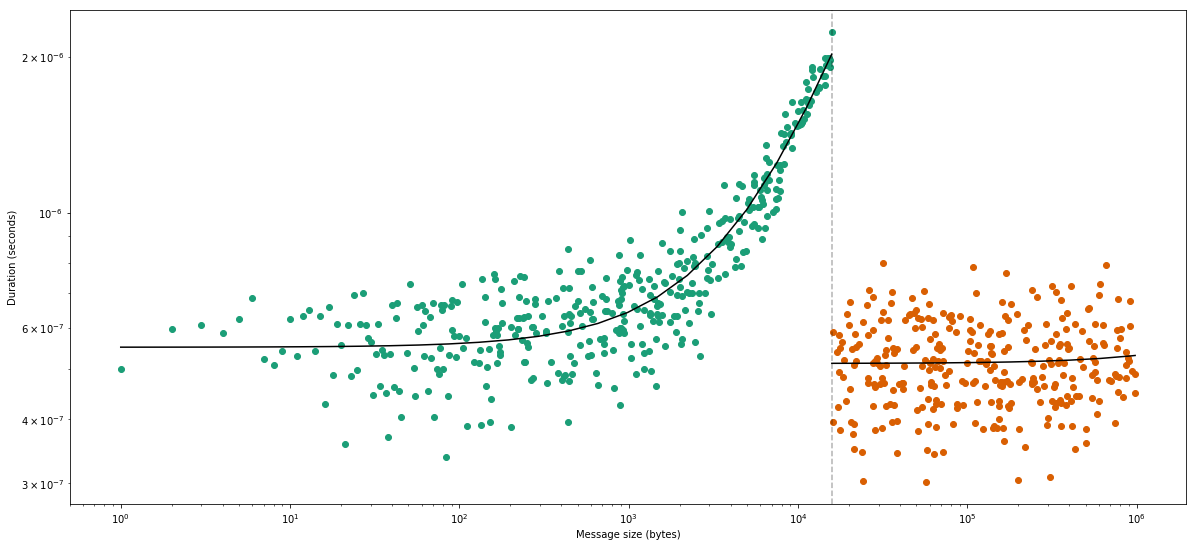

In [9]:
draw_plot(reg_isend)

In [10]:
breakpoints_isend = set(reg_isend.breakpoints)
breakpoints_isend

{15831}

### MPI_Recv

In [11]:
tmp = aggregate_dataframe(df_recv)
reg_recv = pytree.compute_regression(x=tmp.msg_size, y=tmp.duration).auto_simplify()
print(reg_recv.breakpoints)
reg_recv

[15831, 179657, 422239]


-inf < x ≤ 1.583e+04
	y ~ 1.426e-10x + 8.607e-07
1.583e+04 < x ≤ 1.797e+05
	y ~ 4.631e-11x + 1.823e-06
1.797e+05 < x ≤ 4.222e+05
	y ~ 5.040e-11x + 1.138e-06
4.222e+05 < x ≤ inf
	y ~ 5.669e-11x + -1.786e-06

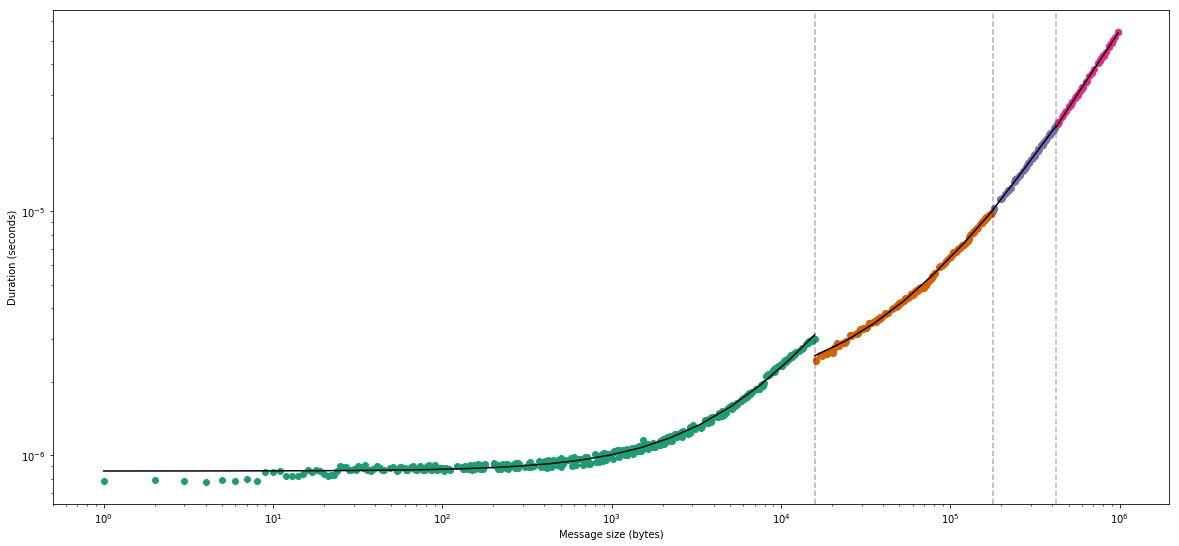

In [12]:
draw_plot(reg_recv)

In [13]:
breakpoints_recv = set(reg_recv.breakpoints)
breakpoints_recv.difference_update([179657, 422239])
breakpoints_recv

{15831}

### Pingpong

In [14]:
tmp = aggregate_dataframe(df_pingpong)
reg_pingpong = pytree.compute_regression(x=tmp.msg_size, y=tmp.duration).auto_simplify()
print(reg_pingpong.breakpoints)
reg_pingpong

[54, 7904, 15831, 66612, 180278, 415013, 827052]


-inf < x ≤ 5.400e+01
	y ~ 8.623e-09x + 1.095e-06
5.400e+01 < x ≤ 7.904e+03
	y ~ 4.314e-10x + 1.391e-06
7.904e+03 < x ≤ 1.583e+04
	y ~ 2.847e-10x + 2.852e-06
1.583e+04 < x ≤ 6.661e+04
	y ~ 8.473e-11x + 3.723e-06
6.661e+04 < x ≤ 1.803e+05
	y ~ 9.192e-11x + 3.497e-06
1.803e+05 < x ≤ 4.150e+05
	y ~ 1.006e-10x + 1.879e-06
4.150e+05 < x ≤ 8.271e+05
	y ~ 1.104e-10x + -2.442e-06
8.271e+05 < x ≤ inf
	y ~ 1.228e-10x + -1.244e-05

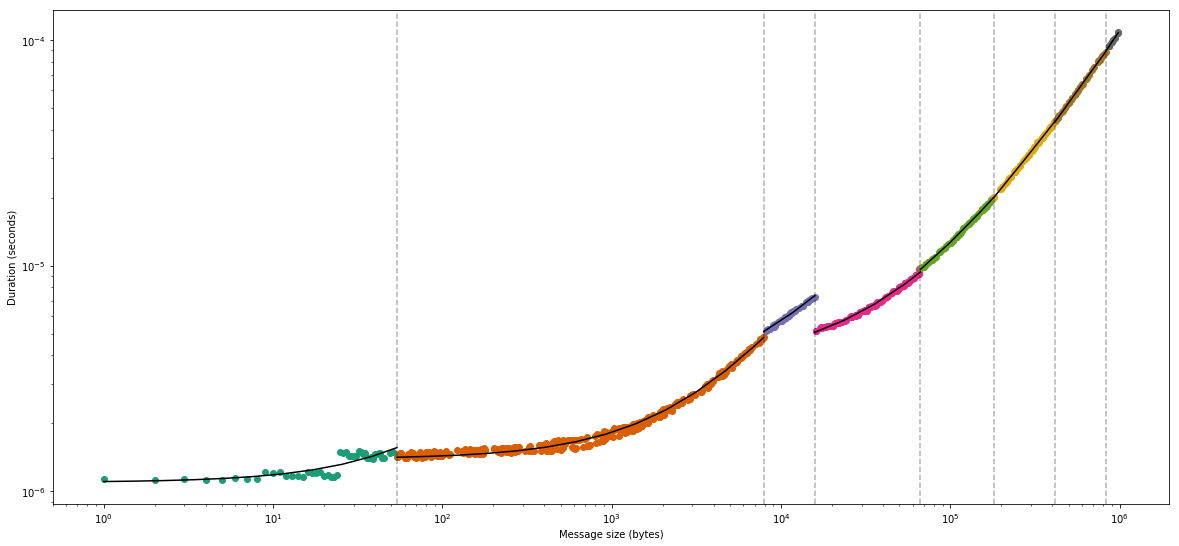

In [15]:
draw_plot(reg_pingpong)

In [16]:
breakpoints_pingpong = set(reg_pingpong.breakpoints)
breakpoints_pingpong.difference_update([54, 66612, 180278, 415013, 827052])
breakpoints_pingpong

{7904, 15831}

## Better regressions

Let's use the same breakpoints everywhere and stop “cleaning” the datasets.

In [17]:
breakpoints = list(sorted(set.union(breakpoints_send, breakpoints_isend, breakpoints_recv, breakpoints_pingpong)))
breakpoints

[7904, 15831, 31183, 65493, 136040]

### MPI_Send

-inf < x ≤ 7.904e+03
	y ~ 8.219e-11x + 2.320e-07
7.904e+03 < x ≤ 1.583e+04
	y ~ 8.343e-11x + 3.775e-07
1.583e+04 < x ≤ 3.118e+04
	y ~ 1.253e-11x + 2.663e-06
3.118e+04 < x ≤ 6.549e+04
	y ~ 4.329e-11x + 1.733e-06
6.549e+04 < x ≤ 1.360e+05
	y ~ 4.285e-11x + 2.058e-06
1.360e+05 < x ≤ inf
	y ~ 5.303e-11x + 9.901e-08


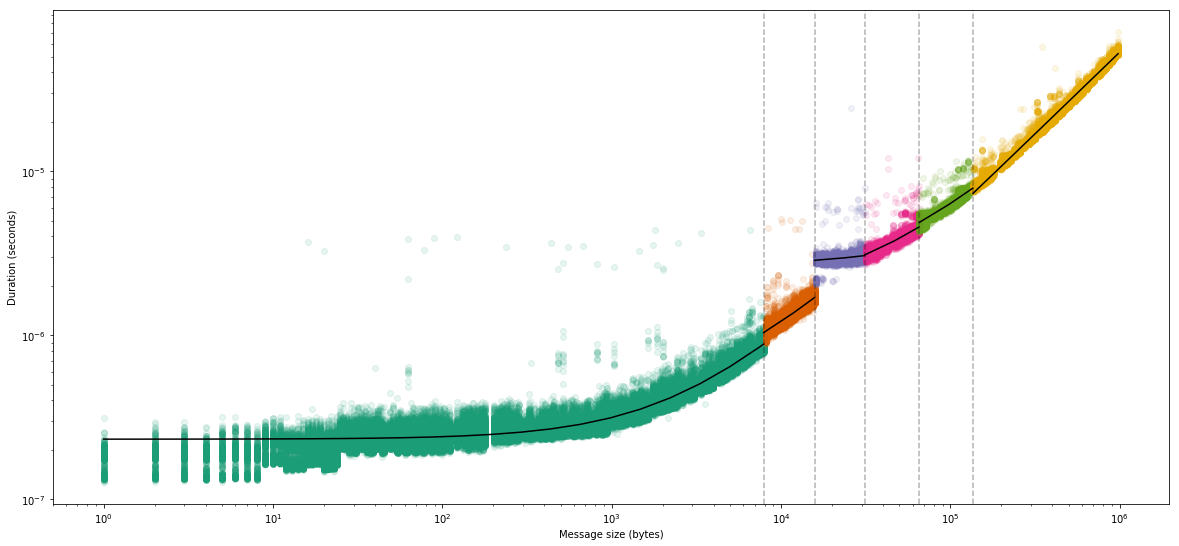

In [18]:
reg_send = pytree.compute_regression(x=df_send.msg_size, y=df_send.duration, breakpoints=breakpoints)
print(reg_send)
draw_plot(reg_send, alpha=0.1)

### MPI_Isend

-inf < x ≤ 7.904e+03
	y ~ 8.332e-11x + 5.609e-07
7.904e+03 < x ≤ 1.583e+04
	y ~ 8.706e-11x + 6.545e-07
1.583e+04 < x ≤ 3.118e+04
	y ~ 4.915e-13x + 4.942e-07
3.118e+04 < x ≤ 6.549e+04
	y ~ -1.731e-12x + 6.037e-07
6.549e+04 < x ≤ 1.360e+05
	y ~ 2.726e-13x + 5.021e-07
1.360e+05 < x ≤ inf
	y ~ 5.739e-14x + 4.895e-07


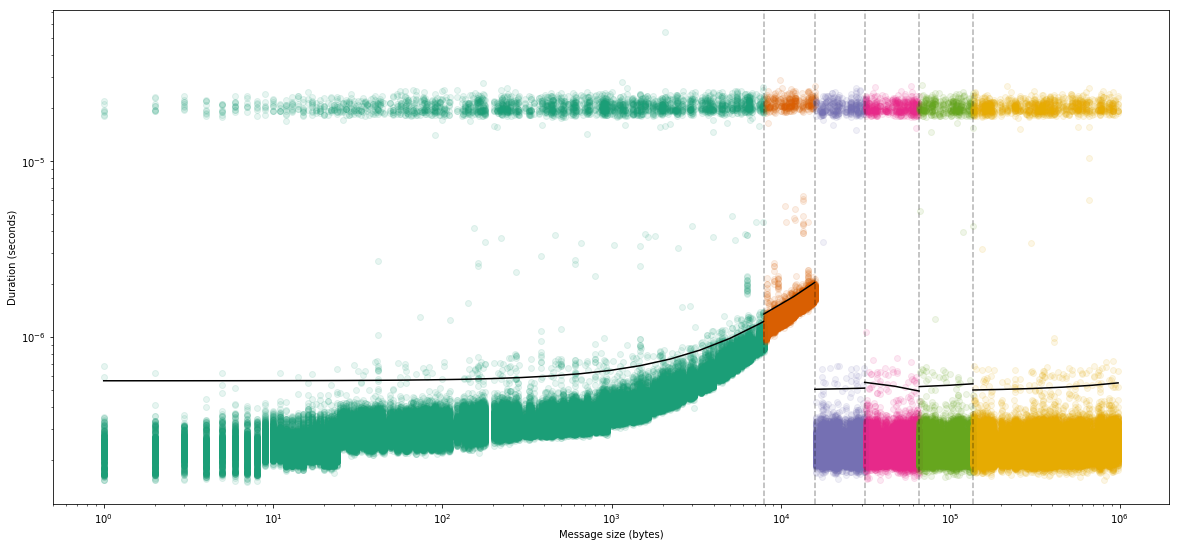

In [19]:
reg_isend = pytree.compute_regression(x=df_isend.msg_size, y=df_isend.duration, breakpoints=breakpoints)
print(reg_isend)
draw_plot(reg_isend, alpha=0.1)

### MPI_Recv

-inf < x ≤ 7.904e+03
	y ~ 1.390e-10x + 8.635e-07
7.904e+03 < x ≤ 1.583e+04
	y ~ 1.204e-10x + 1.141e-06
1.583e+04 < x ≤ 3.118e+04
	y ~ 5.756e-11x + 1.554e-06
3.118e+04 < x ≤ 6.549e+04
	y ~ 4.297e-11x + 2.009e-06
6.549e+04 < x ≤ 1.360e+05
	y ~ 4.809e-11x + 1.617e-06
1.360e+05 < x ≤ inf
	y ~ 5.368e-11x + 2.939e-07


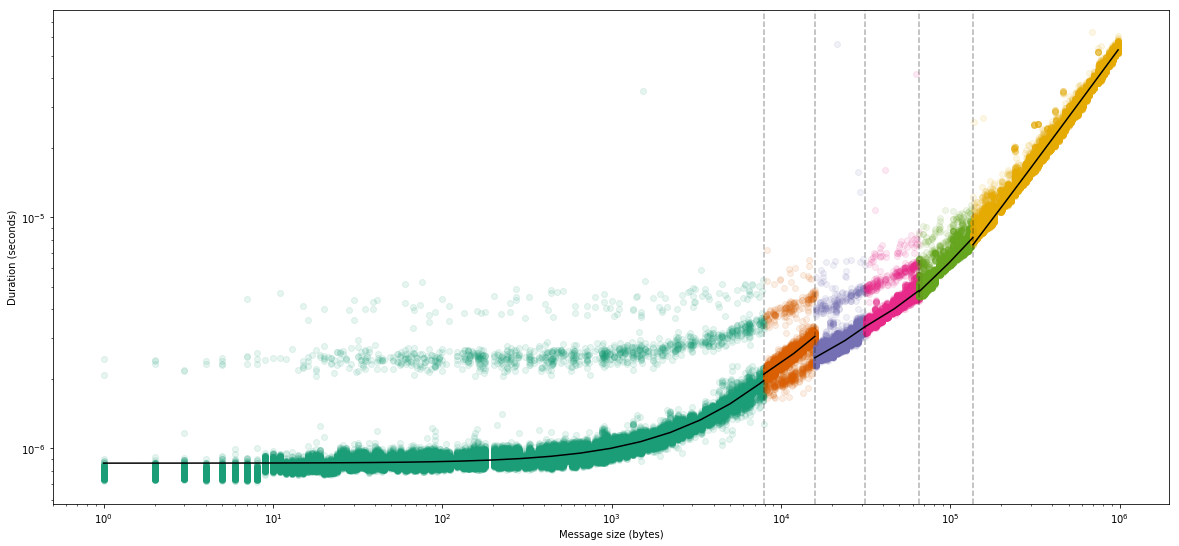

In [20]:
reg_recv = pytree.compute_regression(x=df_recv.msg_size, y=df_recv.duration, breakpoints=breakpoints)
print(reg_recv)
draw_plot(reg_recv, alpha=0.1)

### Pingpong

-inf < x ≤ 7.904e+03
	y ~ 4.360e-10x + 1.371e-06
7.904e+03 < x ≤ 1.583e+04
	y ~ 2.847e-10x + 2.852e-06
1.583e+04 < x ≤ 3.118e+04
	y ~ 7.566e-11x + 3.950e-06
3.118e+04 < x ≤ 6.549e+04
	y ~ 8.665e-11x + 3.609e-06
6.549e+04 < x ≤ 1.360e+05
	y ~ 9.178e-11x + 3.518e-06
1.360e+05 < x ≤ inf
	y ~ 1.068e-10x + 3.239e-07


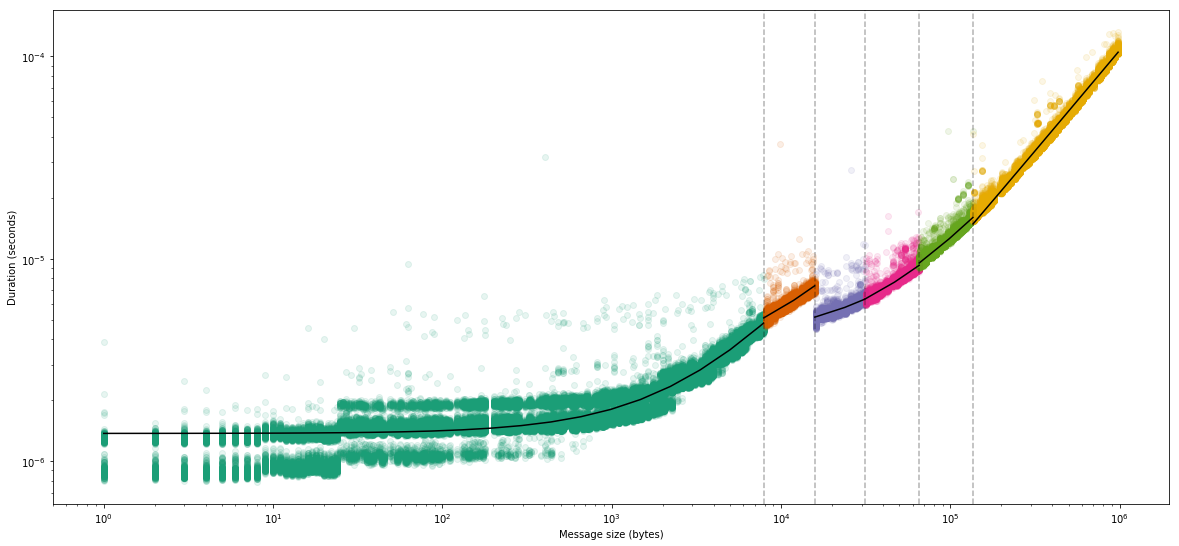

In [21]:
reg_pingpong = pytree.compute_regression(x=df_pingpong.msg_size, y=df_pingpong.duration, breakpoints=breakpoints)
print(reg_pingpong)
draw_plot(reg_pingpong, alpha=0.1)

In [22]:
df_reg_pingpong = reg_pingpong.to_pandas()
df_reg_recv = reg_recv.to_pandas()
df_reg_recv

,MSE,RSS,coefficient,intercept,max_x,min_x
0,2.886268e-14,5.253008e-09,1.389587e-10,8.634518e-07,7.904000e+03,-inf
1,3.036862e-14,7.136626e-10,1.204153e-10,1.140766e-06,1.583100e+04,7.904000e+03
2,1.600214e-13,3.920524e-09,5.755530e-11,1.553500e-06,3.118300e+04,1.583100e+04
3,9.072769e-14,2.903286e-09,4.297346e-11,2.008906e-06,6.549300e+04,3.118300e+04
4,8.403225e-14,2.184839e-09,4.808897e-11,1.616707e-06,1.360400e+05,6.549300e+04
5,8.700479e-13,6.438355e-08,5.367639e-11,2.938795e-07,inf,1.360400e+05


In [23]:
df_reg_transfer = pandas.DataFrame({'min_x': df_reg_pingpong.min_x,
                                    'max_x': df_reg_pingpong.max_x,
                                    'intercept': (df_reg_pingpong.intercept - df_reg_recv.intercept)/2,
                                    'coefficient': (df_reg_pingpong.coefficient - df_reg_recv.coefficient)/2,
                                   })
pandas.set_option('display.float_format', lambda x: '%.2e' % x)
df_reg_transfer

,min_x,max_x,intercept,coefficient
0,-inf,7.90e+03,2.54e-07,1.49e-10
1,7.90e+03,1.58e+04,8.56e-07,8.21e-11
2,1.58e+04,3.12e+04,1.20e-06,9.05e-12
3,3.12e+04,6.55e+04,8.00e-07,2.18e-11
4,6.55e+04,1.36e+05,9.51e-07,2.18e-11
5,1.36e+05,inf,1.50e-08,2.66e-11
